In [83]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
from pathlib import Path
from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage as ndi


%matplotlib inline
%pprint

Pretty printing has been turned ON


In [112]:
class xcam_image:
    
    rotation = 0
    normalization = 1
    pixsize = 55
    picture = None
    picsize = None
    
    def __init__(self, angle, listoflists):
        self.angle = angle
        self.listoflists = listoflists
        
    def get_name(self): return (str(self.angle) + ' Degrees')
    def get_xpixct(self): return (len(self.listoflists[0]))
    def get_ypixct(self): return (len(self.listoflists))
    def get_pixct(self): return (self.get_xpixct() * self.get_ypixct())
    def get_dim(self): return str(self.get_xpixct()*self.pixsize) + ' um x ' + str(self.get_ypixct()*self.pixsize) + ' mm'
    def get_res(self): return (self.get_xpixct(),self.get_ypixct())
    def get_rot(self): return self.rotation
    def get_norm(self): return self.normalization
    def get_pixsize(self): return str(self.pixsize) + ' um'
    def get_base_nparray(self): return np.array(self.listoflists, dtype=np.uint8)
    def get_nparray(self): return np.rot90((self.get_base_nparray()*(int(255 / self.get_norm()))), int(self.get_rot()/90), (-1,0)) 
    def get_com(self): return ndi.center_of_mass(self.get_nparray())
    def get_pic(self): return self.picture
    def get_size(self): return self.picsize
    def get_maxcounts(self):
        maxcount = 0
        xylist = self.listoflists
        for x in range(len(xylist)):
            for y in range(len(xylist[0])):
                if xylist[x][y] > maxcount:
                    maxcount = xylist[x][y]
        return maxcount
        
    def set_pixsize(self, dim): self.pixsize = dim
    def set_size(self, number): self.picsize = number
    def set_norm(self, const): self.normalization = const
    def set_norm_to_max(self): self.normalization = self.get_maxcounts()
    def set_rot(self, n90): 
        if (n90 == 0 or n90 == 90 or n90 == 180 or n90 == 270): self.rotation = n90 
        else: return print('Error: Rotate must be set to 0, 90, 180, or 270 degrees')
    
    #on the fence for how I want these two functions to work
    def gen_pic(self):
        self.picture = im.fromarray(self.get_nparray())
        # display(self.picture) 
        return im.fromarray(self.get_nparray())
    def show_pic(self):
        self.gen_pic()
        if (self.get_size() != None): self.picture = (self.get_pic()).resize(size=(self.get_size(), self.get_size()))
        display(self.picture)
        

In [113]:
class xcam_set:
    
    globe_rotation = None
    globe_normalization = None

    def __init__(self, listofcamobj):
        self.piclist = listofcamobj
    
    def get_len(self): return len(self.piclist)
    def get_angles(self):
        ang = []
        for t in range(self.get_len()):
            ang.append((self.piclist[t]).angle)
        return ang
    def get_com(self): return
    
    def norm(self):
        for t in range(self.get_len()):
            self.piclist[t].set_norm_to_max()
            
    def set_rot(self, n90):
        if (n90 == 0 or n90 == 90 or n90 == 180 or n90 == 270): 
            self.globe_normalization = n90 
            for t in range(self.get_len()):
                self.piclist[t].set_rot(n90)
        else: return print('Error: Rotate must be set to 0, 90, 180, or 270 degrees')

    def set_norm_to_global_max(self):
        gmax = 0
        for t in range(self.get_len()):
            imax = (self.piclist[t]).get_maxcounts()
            if imax > gmax: gmax = imax
        self.globe_normalization = gmax
        for t in range(self.get_len()):
            self.piclist[t].set_norm(gmax)
        
    def show_set(self):
        for t in range(self.get_len()): self.piclist[t].show_pic()

In [114]:
def file_list(directory, ftype):
    allflist = sorted(os.listdir(directory))
    flistlen = len(allflist)
    flist = []
    for x in range(flistlen):
        if allflist[x].endswith(str(ftype)):
            flist.append(allflist[x])
    return flist

def txt_to_list(file):
    rows = []
    processedrows = []

    with open(file, 'r') as f:
        listofrows = f.read().split('\n')
        f.close()

    for i in range(len(listofrows)):
        rowcrawler = []
        rawrow = listofrows[i].split('\t')
        rowlength = len(rawrow)
        for j in range(rowlength):
            if rawrow[j] != '':
                rowcrawler.append(int(rawrow[j]))
        rows.append(rowcrawler)

    #rows is a list of lists, where each entry (i.e. rows[0] is a list reading pixels horizontally across camera
    #rows[5] is a list of each value of every pixel in the 6th row of the image
    #rows[x] has ditched the empty value at the end of each list. But there are 257 rows, not 256. So I need to check that
    #the last row is a real value and not junk

    for j in range(len(rows)):
        if bool(rows[j]):
            processedrows.append(rows[j])
        
    # For example, consider:
    #     1 2 3
    #     4 5 6
    #     7 8 9
    # as a 3x3 pixel camera image. processedrows[0] = [1, 2, 3], and processedrows[2] = [7, 8, 9]
    # processed processedrows[hz index][vt index] accesses that pixel, so processedrows[1][2] = 6
    
    return processedrows

def gen_xcam_set(directory, ftype):
    flist = file_list(directory, ftype)
    #some hardcoded jank right here but it works:
    angles = []
    for q in range(len(flist)):
        angles.append(int((flist[q])[0] + (flist[q])[1]))
    xcam_list = []
    for q in range(len(flist)):
        xcam_list.append(xcam_image(angles[q], txt_to_list(directory + flist[q])))
    setcam = xcam_set(xcam_list)
    return setcam

In [115]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
typ = '.txt'
l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')
# p1 = xcam_image(70, l)
# p1.get_base_nparray()
# p1.set_norm(255)
# p1.set_norm_to_max()
# p1.show_pic()
# deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
# p2 = xcamimage(80, deg80)

# p1.set_norm_to_max()
# p1.set_rot(90)
# p1.gen_pic()
# # p2.gen_pic()



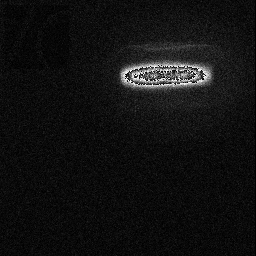

In [134]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
typ = '.txt'
r_tracking = gen_xcam_set(d, typ)
r_tracking.set_rot(270)
# r_tracking.show_set()

l = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/81_deg.txt')
p1 = xcam_image(40, l)
p1.get_maxcounts()
p1.set_norm(80)
# p1.set_norm_to_max()
p1.show_pic()
# deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
# p2 = xcamimage(80, deg80)

# p1.set_norm_to_max()
# p1.set_rot(90)
# p1.gen_pic()
# # p2.gen_pic()



In [117]:
r_tracking = gen_xcam_set(d, typ)
cam_list = r_tracking.piclist
ang = r_tracking.get_angles()
com = []
com_mm = []
for k in range(len(cam_list)):
    if ((k == 3) or (k == 36) or (k == 35)):
        cam_list[k].set_norm(1)
    else:
        cam_list[k].set_norm_to_max()
    cam_list[k].set_rot(270)
    com.append((cam_list[k].get_com())[1])
    com_mm.append(com[k] * .055)

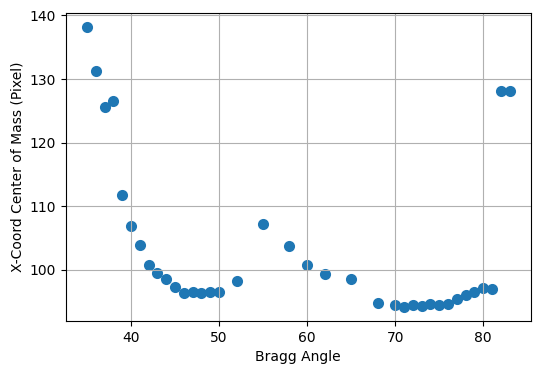

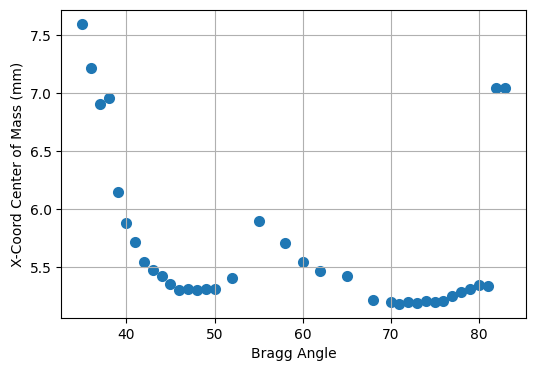

In [118]:
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(ang, com, linewidth=2.0)
ax.set_xlabel('Bragg Angle')
ax.set_ylabel('X-Coord Center of Mass (Pixel)')
ax.grid(True)

fig2, ax2 = plt.subplots(figsize = (6,4))
ax2.scatter(ang, com_mm, linewidth=2.0)
ax2.set_xlabel('Bragg Angle')
ax2.set_ylabel('X-Coord Center of Mass (mm)')
ax2.grid(True)

#camera is about 14mm x 14mm

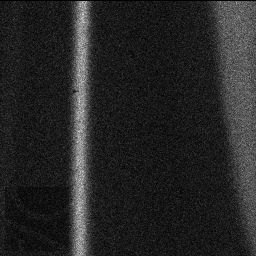

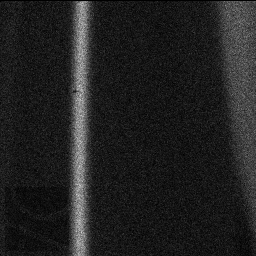

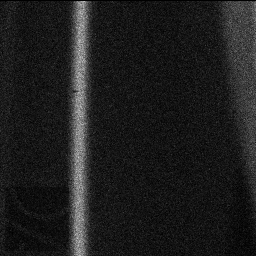

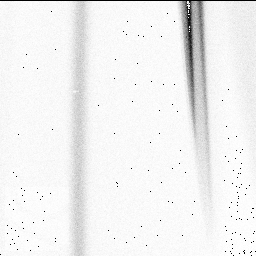

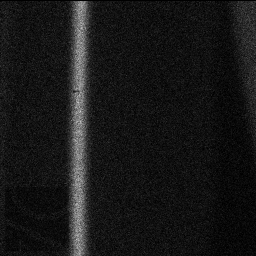

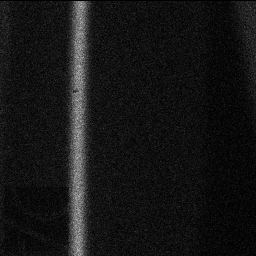

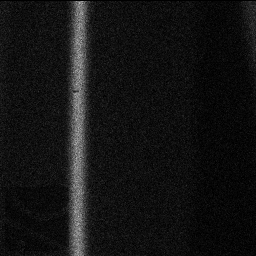

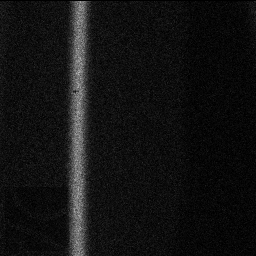

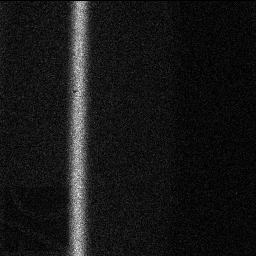

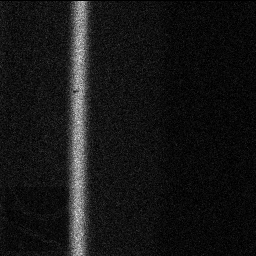

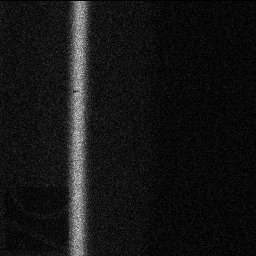

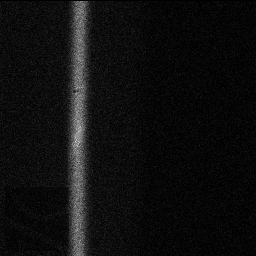

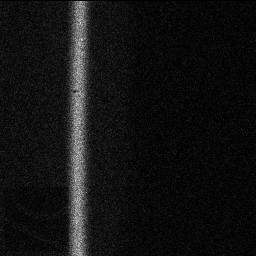

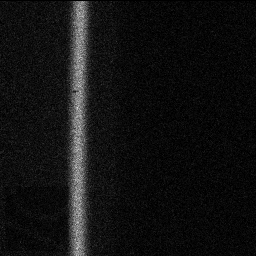

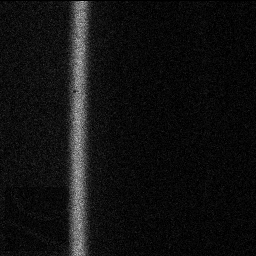

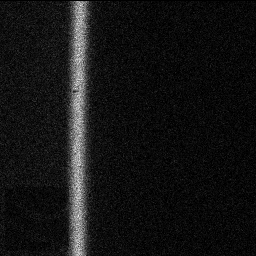

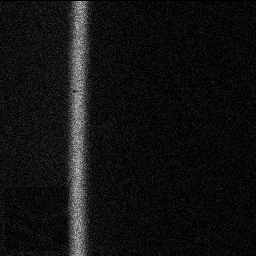

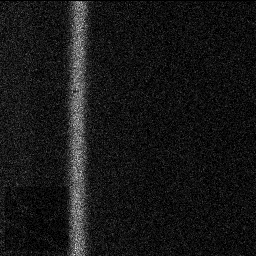

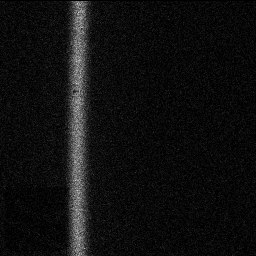

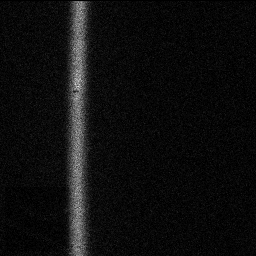

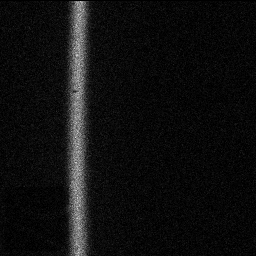

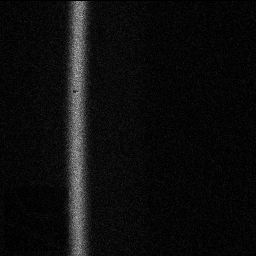

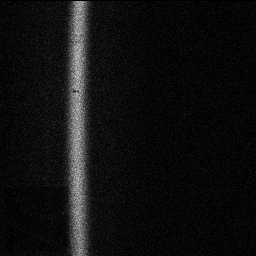

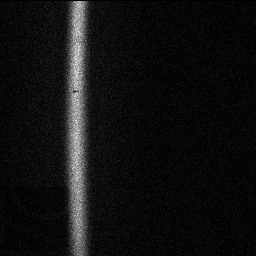

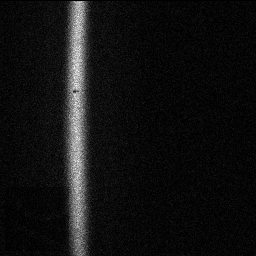

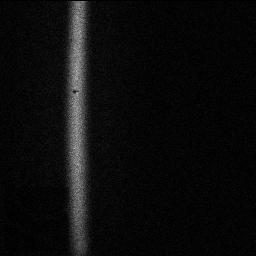

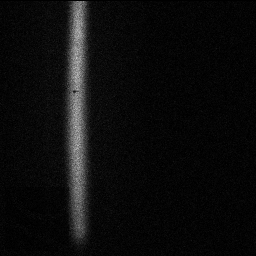

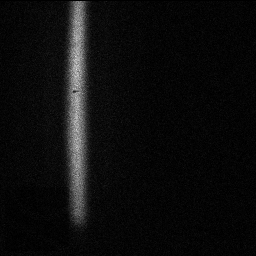

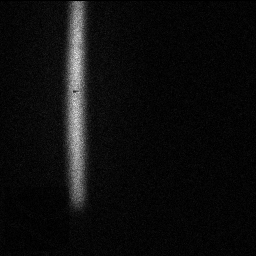

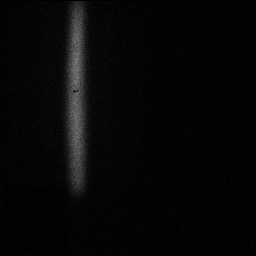

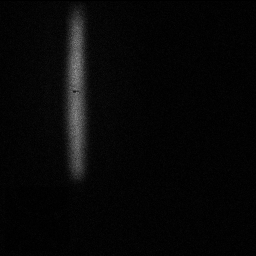

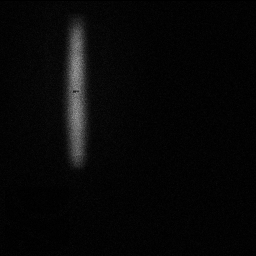

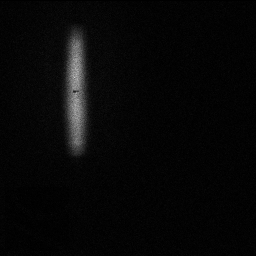

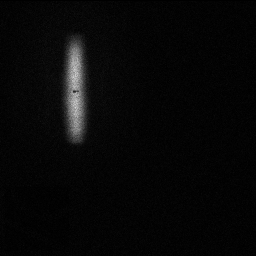

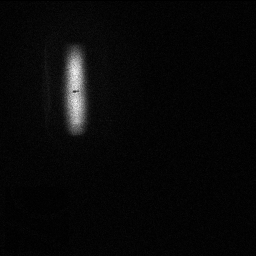

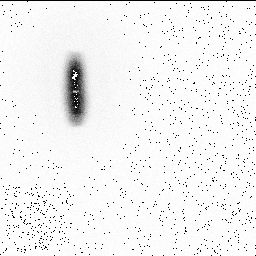

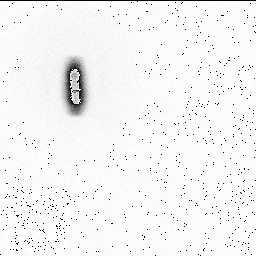

In [119]:
for k in range(len(cam_list)):
    cam_list[k].show_pic()

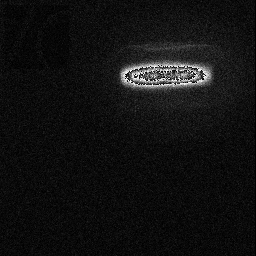

In [135]:
p1.show_pic()

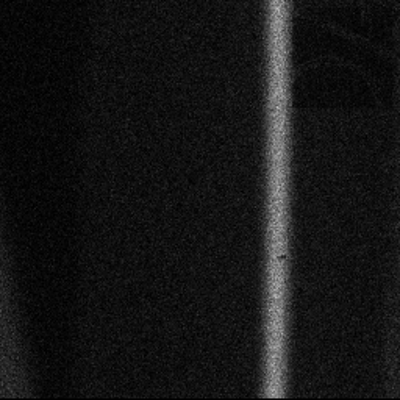

In [134]:
p1.show_pic()

In [136]:
a= p1.get_nparray()
ndi.center_of_mass(a)


(104.86497026640367, 144.63980675542462)

In [ ]:
y = [[1,2,3],[4,5,6],[7,8,9]]
testy = camimage(50, y)
testy.gen_pic()

In [12]:
print(testy.get_name())
print(testy.get_xpixct())
print(testy.get_ypixct())
print(testy.get_pixct())
print(testy.get_dim())
print(testy.get_res())
print(testy.get_rot())
print(testy.get_norm())
print(testy.get_pixsize())
print(testy.get_maxcounts())


50 Degrees
3
3
9
165 um x 165 mm
(3, 3)
0
1
55 um
9


In [13]:
testy.set_norm(10)
testy.set_rot(90)
testy.set_pixsize(55)
testy.set_norm_to_max()

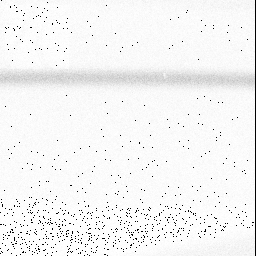

In [30]:
deg40 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/40_deg.txt')
p1 = camimage(40, deg40)
deg80 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/80_deg.txt')
p2 = camimage(80, deg80)

p1.pic()

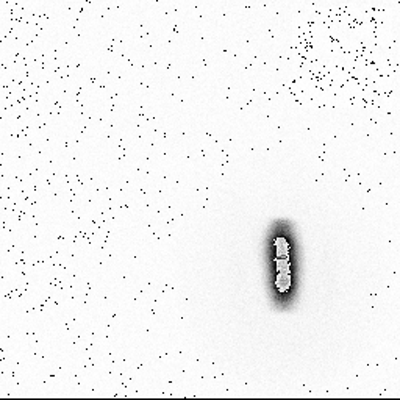

In [42]:
deg40 = txt_to_list('/Users/anthonygironda/Desktop/Rowland_Tracking/83_deg.txt')
p1 = camimage(80, deg40)
p1.pic()
p1.set_rot(90)
p1.pic()
# im.fromarray(p1.p1.rotate(90)imagearray)
img = p1.pic()
img.resize(size=(400, 400))
